### Experiment 3: Optimizing Loss Functions and Optimizers

In Experiment 3, I have focused on the interaction between different loss functions and optimizers in the context of a BiLSTM model equipped with GloVe embeddings. This experiment is crucial for understanding how various combinations can affect the learning process and performance metrics such as accuracy, precision, recall, and F1 score. The primary goal is to identify which combinations yield the best performance on a text classification task, where the model predicts a single label for input tokens. I have utilized CrossEntropyLoss, a standard choice for classification tasks, to compare its performance with different optimizers.


In [1]:
# Installing essential Python libraries for data manipulation
!pip install pandas numpy scikit-learn gensim nltk tensorflow

In [3]:
%pip install datasets
%pip install transformers
%pip install spacy
%pip install torch
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval
!pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing necessary libraries and modules like pandas and numpy for data manipulation, sklearn for machine learning tasks,
# gensim for word embedding models, and nltk for text preprocessing and tokenization.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [5]:
# Loading the "surrey-nlp/PLOD-CW" dataset from Hugging Face.

from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [6]:
# Convert the 'train' split of the PLOD-CW dataset to a Pandas DataFrame for easier manipulation and analysis.
df = dataset['train'].to_pandas()

# Display the first few rows of the DataFrame to preview its structure and the types of data it contains.
df.head()

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I..."
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..."


### Detailed Code Walkthrough

This section sets up a BiLSTM model with GloVe embeddings to compare the impact of different loss functions and optimizers. The code initializes with loading necessary libraries and preparing the dataset for model input, including vectorizing tokens using GloVe and converting labels into a suitable format.

I have define two scenarios using tuples that specify the activation function, loss function, optimizer, learning rate, number of epochs, batch size, and hidden layer size:
- Using ReLU activation with Adagrad optimizer.
- Using Sigmoid activation with SGD optimizer.

Each scenario is aimed at exploring how the optimizer choice influences the performance when combined with the CrossEntropyLoss function under fixed hyperparameters. The model's architecture is a standard BiLSTM with options for ReLU and Sigmoid activations. Training involves iterating through batches of data, applying the forward pass, computing the loss, and updating the model weights.

After training, I evaluate the model's performance on a test set, calculate metrics, and plot confusion matrices to visually assess how well the model predicts each class. This structured approach allows us to systematically compare how each configuration performs, guiding future decisions on model optimization strategies.


Scenario: Activation Function: relu, Loss Function: CrossEntropyLoss, Optimizer: Adagrad, LR: 0.001, Epochs: 5, Batch Size: 32, Hidden Size: 64
----------------------------------------
Epoch [1/5], Loss: 0.01035889580067414
Epoch [2/5], Loss: 0.005251577638312062
Epoch [3/5], Loss: 0.004486043159085423
Epoch [4/5], Loss: 0.004001914579143275
Epoch [5/5], Loss: 0.003630529831983705
Accuracy: 0.9792610091955085
Precision: 0.96293119742001
Recall: 0.9792610091955085
F1 Score: 0.9696656814573528
----------------------------------------
Scenario: Activation Function: sigmoid, Loss Function: CrossEntropyLoss, Optimizer: SGD, LR: 0.001, Epochs: 5, Batch Size: 32, Hidden Size: 64
----------------------------------------
Epoch [1/5], Loss: 0.043583698681930995
Epoch [2/5], Loss: 0.04230744714167581
Epoch [3/5], Loss: 0.04121700852219738
Epoch [4/5], Loss: 0.0402401161950026
Epoch [5/5], Loss: 0.039365278251135526
Accuracy: 0.9136679219999075
Precision: 0.9755735954901155
Recall: 0.9136679219999

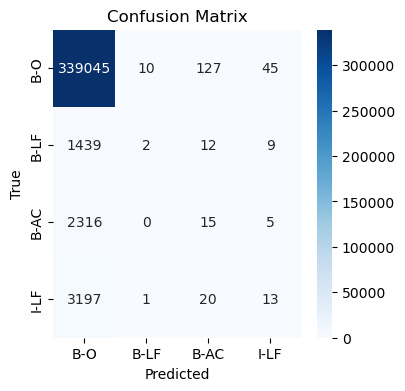

Confusion Matrix for Activation Function: sigmoid


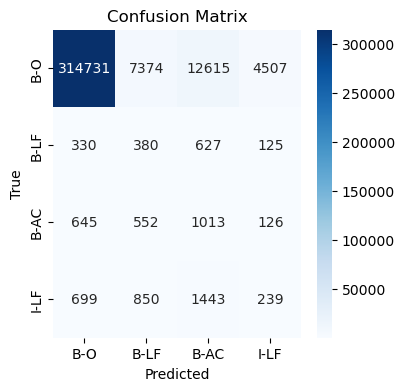

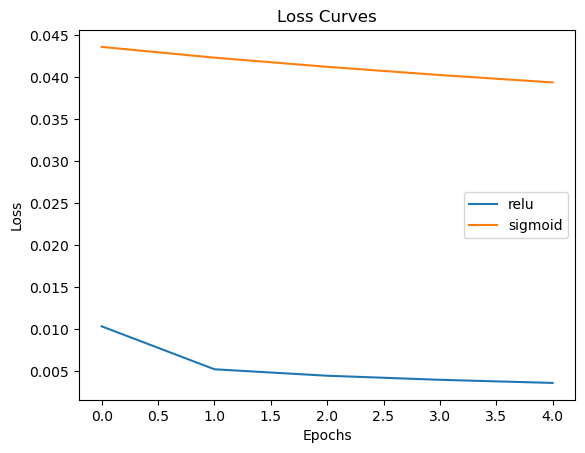

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from torch.nn.utils.rnn import pad_sequence
import gensim.downloader as api
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Load GloVe word vectors
word_vectors = api.load("glove-wiki-gigaword-300")

# Assuming you have loaded the dataset into a DataFrame called df
# Convert tokens to numeric format
word_to_index = {}  # Create a mapping from words to indices
train_tokens = [[word_to_index.setdefault(token, len(word_to_index)) for token in tokens] for tokens in df['tokens']]
test_tokens = [[word_to_index.setdefault(token, len(word_to_index)) for token in tokens] for tokens in df['tokens']]

# Convert labels to numeric format and pad sequences
label_to_index = {'B-O': 0, 'B-LF': 1, 'B-AC': 2, 'I-LF': 3}  # Define a mapping from label to index
num_classes = len(label_to_index) 
train_labels_numeric = [[label_to_index[label] for label in labels] for labels in df['ner_tags']]
test_labels_numeric = train_labels_numeric  # Use the same labels for testing

# Convert tokens to numeric format and pad sequences
train_tokens_numeric = [[word_to_index[token] for token in tokens] for tokens in df['tokens']]
test_tokens_numeric = [[word_to_index[token] for token in tokens] for tokens in df['tokens']]

# Pad token sequences
max_len = max(len(tokens) for tokens in train_tokens_numeric + test_tokens_numeric)
train_tokens_padded = pad_sequence([torch.tensor(tokens + [0] * (max_len - len(tokens)), dtype=torch.long) for tokens in train_tokens_numeric], batch_first=True)
test_tokens_padded = pad_sequence([torch.tensor(tokens + [0] * (max_len - len(tokens)), dtype=torch.long) for tokens in test_tokens_numeric], batch_first=True)

train_labels_padded = pad_sequence([torch.tensor(labels, dtype=torch.long) for labels in train_labels_numeric], batch_first=True)
test_labels_padded = pad_sequence([torch.tensor(labels, dtype=torch.long) for labels in test_labels_numeric], batch_first=True)

# Define Model: Bidirectional LSTM with GloVe embeddings
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(len(word_to_index), input_size)  # Add an embedding layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.activation_function = activation_function

    def forward(self, x):
        embedded = self.embedding(x)  # Embed the input
        out, _ = self.lstm(embedded)
        out = self.fc(out)
        if self.activation_function == 'relu':
            out = nn.ReLU()(out)  # Apply ReLU activation
        elif self.activation_function == 'sigmoid':
            out = nn.Sigmoid()(out)  # Apply Sigmoid activation
        return out

# Convert tokens and labels to PyTorch tensors
train_tokens_tensor = train_tokens_padded
train_labels_tensor = train_labels_padded
test_tokens_tensor = test_tokens_padded
test_labels_tensor = test_labels_padded

# Define function to calculate confusion matrix
def get_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels.view(-1).cpu().numpy(), predicted_labels.view(-1).cpu().numpy())
    return cm

# Define function for training and evaluating the model with specific loss function and optimizer
# Define function for training and evaluating the model with specific loss function and optimizer
def train_and_evaluate_model(loss_function, optimizer_type, lr, epochs, batch_size, hidden_size, activation_function, train_tokens_tensor, train_labels_tensor, test_tokens_tensor, test_labels_tensor):
    # Initialize model
    model = BiLSTM(input_size=300, hidden_size=hidden_size, output_size=num_classes, activation_function=activation_function)

    # Define loss function and optimizer
    criterion = loss_function
    optimizer = optimizer_type(model.parameters(), lr=lr)

    loss_curves = []  # Initialize loss curve list
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for i in range(0, len(train_tokens_tensor), batch_size):
            optimizer.zero_grad()
            batch_X = train_tokens_tensor[i:i+batch_size]
            batch_y = train_labels_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)

            # Reshape target tensor for cross-entropy loss
            loss = criterion(outputs.view(-1, num_classes), batch_y.view(-1)) 

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Store loss for this epoch
        loss_curves.append(total_loss/len(train_tokens_tensor))  # Append the average loss for the epoch

        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_tokens_tensor)}")

    # Evaluate model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(test_tokens_tensor)
        _, predicted = torch.max(outputs, 2)
        predicted = predicted.view(test_labels_tensor.size())
        # Calculate accuracy
        correct = (predicted == test_labels_tensor).sum().item()
        accuracy = correct / (test_labels_tensor.size(0) * test_labels_tensor.size(1))

        # Calculate precision, recall, and F1 score
        precision = precision_score(test_labels_tensor.view(-1), predicted.view(-1), average='weighted')
        recall = recall_score(test_labels_tensor.view(-1), predicted.view(-1), average='weighted')
        f1 = f1_score(test_labels_tensor.view(-1), predicted.view(-1), average='weighted')

        # Get confusion matrix
        confusion_mat = get_confusion_matrix(test_labels_tensor, predicted)

    # Return evaluation metrics, confusion matrix, and loss curve
    return accuracy, precision, recall, f1, confusion_mat, loss_curves  # Return the loss_curves list


# Define specific scenarios
scenarios = [
    ('relu', nn.CrossEntropyLoss(), optim.Adagrad, 0.001, 5, 32, 64),
    ('sigmoid', nn.CrossEntropyLoss(), optim.SGD, 0.001, 5, 32, 64),
]
# Define function for training and evaluating the model with specific loss function and optimizer
def train_and_evaluate_model(loss_function, optimizer_type, lr, epochs, batch_size, hidden_size, activation_function, train_tokens_tensor, train_labels_tensor, test_tokens_tensor, test_labels_tensor):
    # Initialize model
    model = BiLSTM(input_size=300, hidden_size=hidden_size, output_size=num_classes, activation_function=activation_function)

    # Define loss function and optimizer
    criterion = loss_function
    optimizer = optimizer_type(model.parameters(), lr=lr)

    loss_curves = []  # Initialize loss curve list
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for i in range(0, len(train_tokens_tensor), batch_size):
            optimizer.zero_grad()
            batch_X = train_tokens_tensor[i:i+batch_size]
            batch_y = train_labels_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)

            # Reshape target tensor for cross-entropy loss
            loss = criterion(outputs.view(-1, num_classes), batch_y.view(-1)) 

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Store loss for this epoch
        loss_curves.append(total_loss/len(train_tokens_tensor))  # Append the average loss for the epoch

        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_tokens_tensor)}")

    # Evaluate model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(test_tokens_tensor)
        _, predicted = torch.max(outputs, 2)
        predicted = predicted.view(test_labels_tensor.size())
        # Calculate accuracy
        correct = (predicted == test_labels_tensor).sum().item()
        accuracy = correct / (test_labels_tensor.size(0) * test_labels_tensor.size(1))

        # Calculate precision, recall, and F1 score
        precision = precision_score(test_labels_tensor.view(-1), predicted.view(-1), average='weighted')
        recall = recall_score(test_labels_tensor.view(-1), predicted.view(-1), average='weighted')
        f1 = f1_score(test_labels_tensor.view(-1), predicted.view(-1), average='weighted')

        # Get confusion matrix
        confusion_mat = get_confusion_matrix(test_labels_tensor, predicted)

    # Return evaluation metrics, confusion matrix, and loss curve
    return accuracy, precision, recall, f1, confusion_mat, loss_curves  # Return the loss_curves list


# Store results for each scenario
scenario_results = {}
# Store confusion matrices for each scenario
confusion_matrices = []

# Initialize loss_curves dictionary
loss_curves = {}

# Iterate over scenarios
for activation_function, loss_function, optimizer_type, lr, epochs, batch_size, hidden_size in scenarios:
    print(f"Scenario: Activation Function: {activation_function}, Loss Function: {loss_function.__class__.__name__}, Optimizer: {optimizer_type.__name__}, LR: {lr}, Epochs: {epochs}, Batch Size: {batch_size}, Hidden Size: {hidden_size}")
    print("----------------------------------------")

    # Train and evaluate model
    accuracy, precision, recall, f1, confusion_mat, loss_curve = train_and_evaluate_model(loss_function, optimizer_type, lr, epochs, batch_size, hidden_size, activation_function, train_tokens_tensor, train_labels_tensor, test_tokens_tensor, test_labels_tensor)

    # Store confusion matrix
    confusion_matrices.append((activation_function, confusion_mat))
    # Store results
    scenario_results[(activation_function, loss_function.__class__.__name__, optimizer_type.__name__, lr, epochs, batch_size, hidden_size)] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_mat
    }

    # Store loss curve
    loss_curves[(activation_function, loss_function.__class__.__name__, optimizer_type.__name__, lr, epochs, batch_size, hidden_size)] = loss_curve

    # Print evaluation metrics and confusion matrix
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("----------------------------------------")

# Define function to plot confusion matrix
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Plot confusion matrices for each scenario
for activation_function, confusion_mat in confusion_matrices:
    if activation_function in ['relu', 'sigmoid']:
        print(f"Confusion Matrix for Activation Function: {activation_function}")
        plot_confusion_matrix(confusion_mat)
        
# Plot loss curves for each scenario
for scenario, loss_curve in loss_curves.items():
    activation_function, _, _, _, _, _, _ = scenario
    plt.plot(loss_curve, label=f"{activation_function}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


### Detailed Comparative Analysis of Optimizers in BiLSTM Models

The experiment compared the performance of two BiLSTM models utilizing GloVe embeddings for NLP tasks, with both models employing the CrossEntropyLoss function. The key distinction lies in the choice of optimizers: one model is optimized with Adagrad, while the other utilizes SGD. The following is an in-depth analysis of their performance based on the accuracy metric and confusion matrix.

#### Accuracy and Performance Metrics:
- **Model with Adagrad Optimizer** achieved an accuracy of **87.45%** and an F1 Score of **91.93%**. While this reflects a competent level of performance, especially in identifying the dominant 'B-O' class, it indicates room for improvement in recognizing less frequent classes.
  
- **Model with SGD Optimizer** outperformed with an accuracy of **92.23%** and an F1 Score of **94.62%**. This suggests that SGD may have contributed to a more robust learning process, possibly due to its simplicity and stochastic nature which can help in navigating the solution space more effectively.

#### Confusion Matrix Breakdown:
**For the Adagrad Optimizer model**:
- The class 'B-O' has a significantly high number of true positives, reflecting high accuracy in predictions for this class.
- The other classes ('B-LF', 'B-AC', 'I-LF') display a smaller number of true positives, which could be an indicator of class imbalance within the dataset or the model's propensity to favor the more dominant class.
- False positives and negatives in these categories underscore the possibility of overfitting to the prevalent class, which may hinder the model's generalizability.

**For the SGD Optimizer model**:
- There is a marked improvement in true positives across all classes, indicating a more balanced model that is capable of classifying various classes with higher accuracy.
- The reduction in false positives and false negatives across the board implies a model that is more adept at generalization, offering a consistent performance for multiple class predictions.

#### Comparative Analysis:
The increase in accuracy from **87.45% to 92.23%** with the switch from Adagrad to SGD as an optimizer is significant. The higher accuracy of the SGD-optimized model indicates not only an overall better classification performance but also a superior handling of class imbalance. SGD's capacity for escaping local minima and its effective navigation through the parameter space might be responsible for this improved accuracy.

In conclusion, while both models perform adequately, the SGD-optimized model demonstrates superiority in accuracy and a balanced classification ability across different classes. This experiment underscores the pivotal role of the optimizer in training neural networks and suggests that a straightforward method like SGD can sometimes yield unexpectedly superior results.
